<a href="https://colab.research.google.com/github/emanbuc/ultrasonic-vision/blob/main/create_training_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisi dati di training per le varie classi di oggetti

# Explore Dataset
Load full dataset into a Pandas dataframe. A small dataset (500 rows) can be fully loaded in memory.

Time column is not relevant for classification and in not included in dataframe

In [16]:
# Univariate Histograms
import matplotlib.pyplot as plt
import pandas
url = "https://raw.githubusercontent.com/emanbuc/ultrasonic-vision/main/sample_acquisitions/7sensors/20210102/20210102_alldata.csv"

names = ['HCSR04_001', 'HCSR04_002', 'HCSR04_003', 'HCSR04_004', 'HCSR04_005', 'HCSR04_006', 'HCSR04_007']
data = pandas.read_csv(url, usecols=names)
print(data)

     HCSR04_001  HCSR04_002  HCSR04_003  ...  HCSR04_005  HCSR04_006  HCSR04_007
0         53.25       54.19       56.01  ...       50.57       51.90       23.33
1         53.21       54.23       55.98  ...       50.49       51.39      117.41
2         53.16       54.62       56.41  ...       50.11       51.91      109.82
3         53.18       54.64       56.03  ...       50.49       51.44      104.63
4         53.31       54.58       56.39  ...       50.11       51.40      105.24
..          ...         ...         ...  ...         ...         ...         ...
496       40.35       19.25       38.56  ...       30.85       57.15      119.41
497       40.43       19.68       38.56  ...       30.86       57.93      112.06
498       40.34       19.70       38.49  ...       30.91       57.62      111.50
499       40.42       19.70       38.51  ...       30.90       57.91      111.54
500       40.30       19.31       38.57  ...       30.96       57.53      110.89

[501 rows x 7 columns]


## Univariate Plots

### Histogram

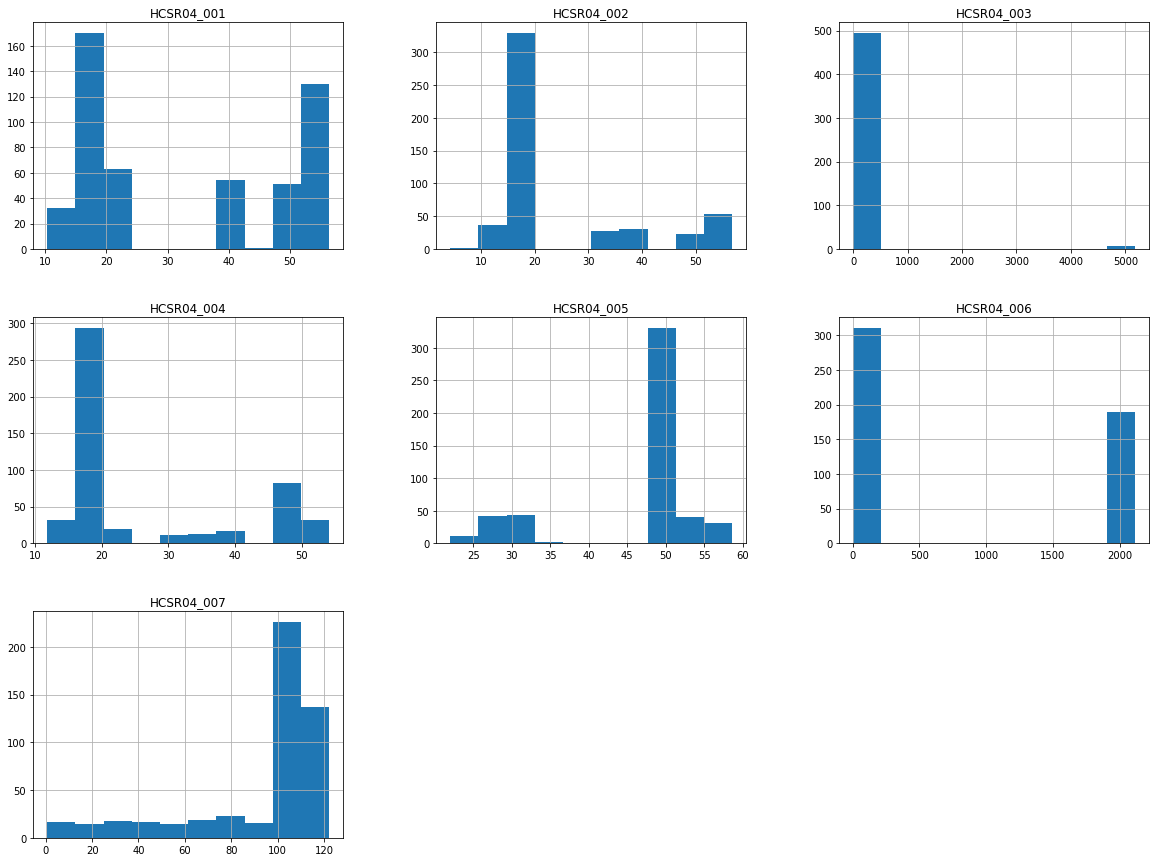

In [17]:
data.hist(figsize=(20,15))
plt.show()

### Density Plots


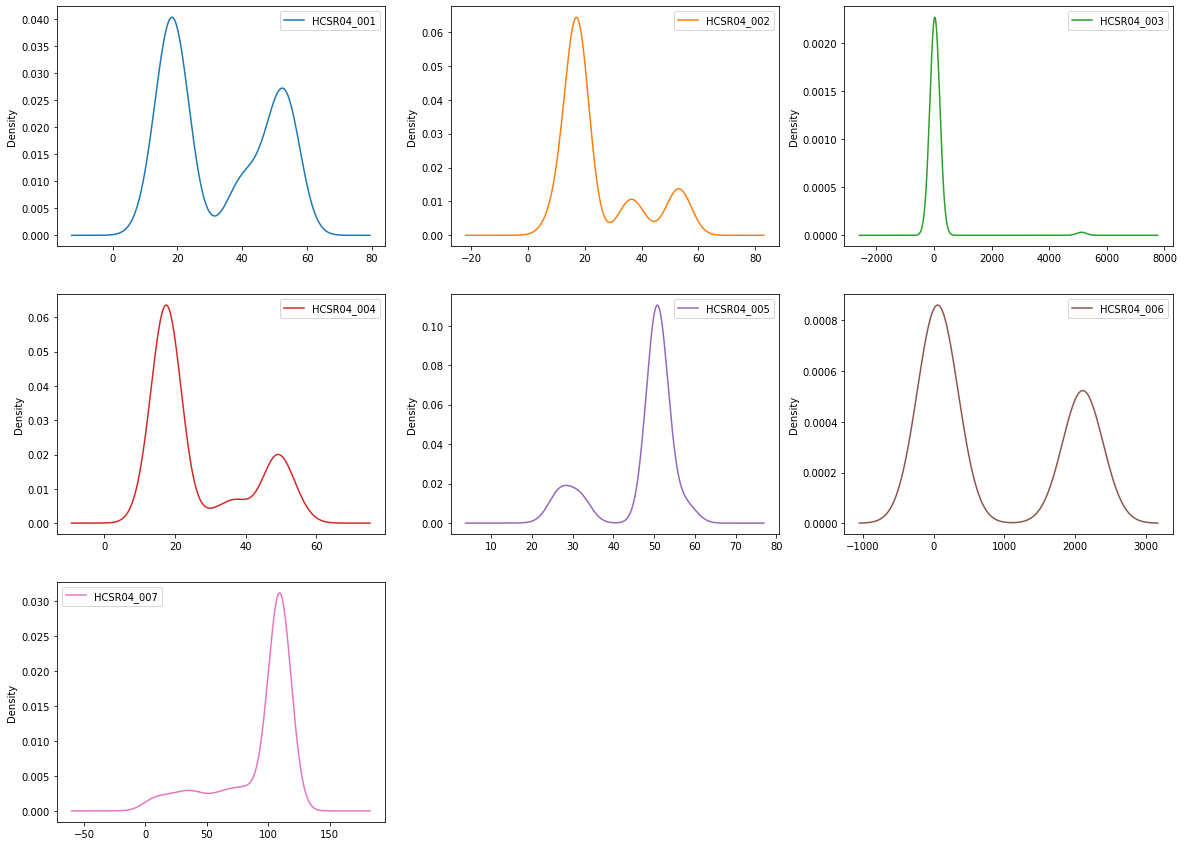

In [18]:
data.plot(kind='density', subplots=True, layout=(3,3), sharex=False, figsize=(20,15))
plt.show()

### Box and Whisker Plots (Boxplot)
Boxplots summarize the distribution of each attribute, drawing a line for the median (middle value) and a box around the 25th and 75th percentiles (the middle 50% of the data). The whiskers give an idea of the spread of the data and dots outside of the whiskers show candidate outlier values (values that are 1.5 times greater than the size of spread of the middle 50% of the data).

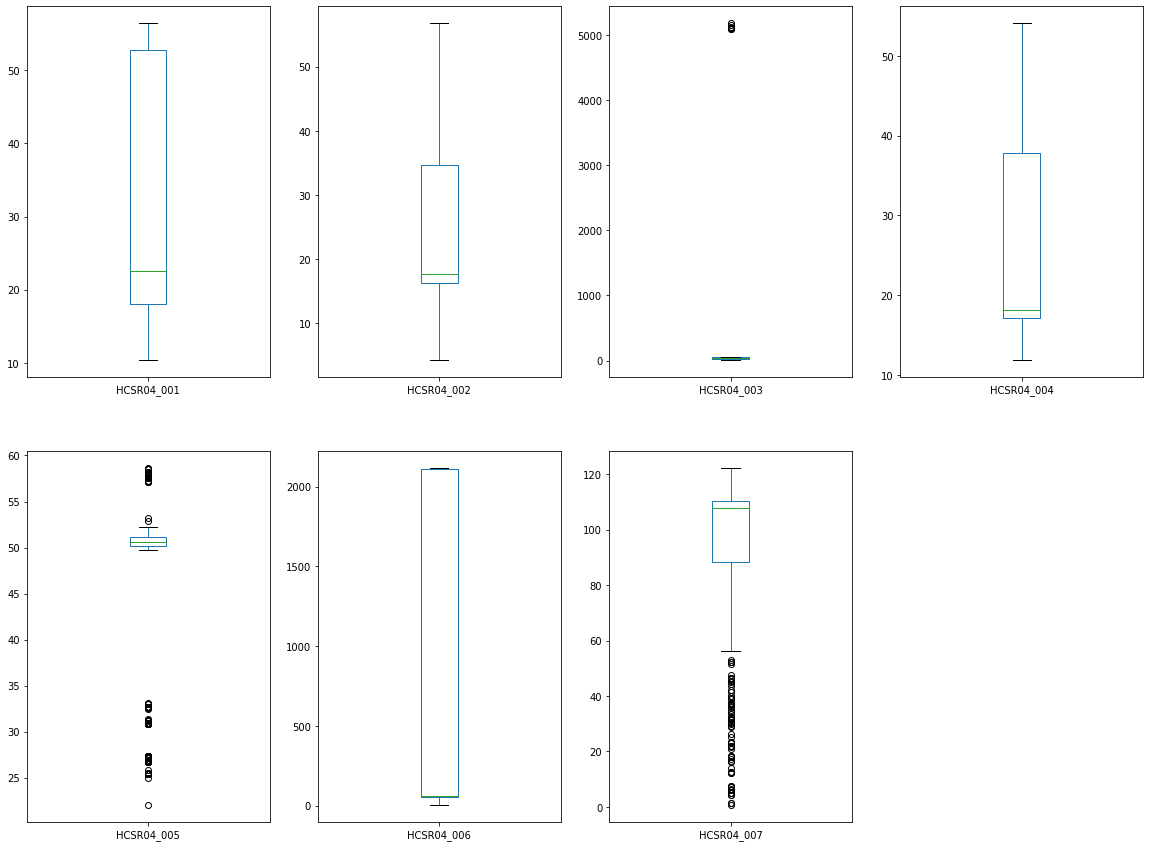

In [19]:
data.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False,figsize=(20,15))
plt.show()

### Osservazioni
Nella configurazione "seven sensors" l'area di misura era delimitata da pannelli in cartone posizionati parallelemente al piano frontale dei sensori a distanze comprese tra i 50 e 60 cm.  L'analisi dei dati acquisiti mostra la presenza di numerose misure anomale




#### Analisi anomalie HCSR04_007

Analisi dei dati prodotti da HCSR04_007 senza nessun oggetto presente

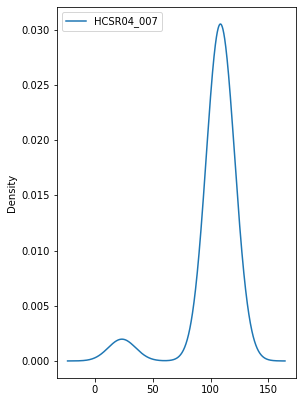

,HCSR04_007,ObjectClass
0,23.33,EMPTY_SEVEN
1,117.41,EMPTY_SEVEN
2,109.82,EMPTY_SEVEN
3,104.63,EMPTY_SEVEN
4,105.24,EMPTY_SEVEN
5,109.74,EMPTY_SEVEN
6,105.13,EMPTY_SEVEN
7,110.76,EMPTY_SEVEN
8,106.17,EMPTY_SEVEN
9,110.48,EMPTY_SEVEN


In [33]:
names = ['HCSR04_007','ObjectClass']
data_HCSR04_007 = pandas.read_csv(url, usecols=names)
HCSR04_007_grouped= data_HCSR04_007.groupby(['ObjectClass'])
HCSR04_007_EMPTY_SEVEN= HCSR04_007_grouped.get_group('EMPTY_SEVEN')

HCSR04_007_EMPTY_SEVEN.plot(kind='density', subplots=True, layout=(2,6), sharex=False, figsize=(30,15))
plt.show()
HCSR04_007_EMPTY_SEVEN

C'è un sistematico su HCSR04_007 che sposta il picco intorno a 100 cm piuttosto che inntorno a 50 cm. 

#### Analisi anomalie HCSR04_006

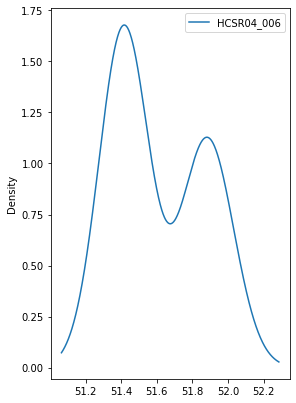

,HCSR04_006,ObjectClass
0,51.90,EMPTY_SEVEN
1,51.39,EMPTY_SEVEN
2,51.91,EMPTY_SEVEN
3,51.44,EMPTY_SEVEN
4,51.40,EMPTY_SEVEN
5,51.37,EMPTY_SEVEN
6,51.83,EMPTY_SEVEN
7,51.82,EMPTY_SEVEN
8,51.40,EMPTY_SEVEN
9,51.46,EMPTY_SEVEN


In [31]:
names = ['HCSR04_006','ObjectClass']
data_HCSR04_006 = pandas.read_csv(url, usecols=names)
HCSR04_006_grouped= data_HCSR04_006.groupby(['ObjectClass'])
HCSR04_006_EMPTY_SEVEN= HCSR04_006_grouped.get_group('EMPTY_SEVEN')

HCSR04_006_EMPTY_SEVEN.plot(kind='density', subplots=True, layout=(2,6), sharex=False, figsize=(30,15))
plt.show()
HCSR04_006_EMPTY_SEVEN

In [ ]:
il sensore sembra funzionare correttamente. Le misure anomale (outliar) sono probabilmente da attribuire a fenomeni di multipath e scattering

# Multivariate Plots
Examples of plots with interactions between multiple variables.

## Correlation Matrix Plot
Correlation gives an indication of how related the changes are between two variables. If two variables change in the same direction they are positively correlated. If the change in opposite directions together (one goes up, one goes down), then they are negatively correlated.

You can calculate the correlation between each pair of attributes. This is called a correlation matrix. You can then plot the correlation matrix and get an idea of which variables have a high correlation with each other.

This is useful to know, because some machine learning algorithms like linear and logistic regression can have poor performance if there are highly correlated input variables in your data.

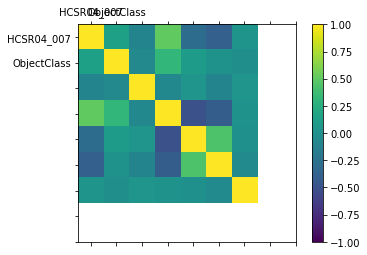

In [34]:
# Correction Matrix Plot
import matplotlib.pyplot as plt
import pandas
import numpy
correlations = data.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

### Scatterplot Matrix
A scatterplot shows the relationship between two variables as dots in two dimensions, one axis for each attribute. You can create a scatterplot for each pair of attributes in your data. Drawing all these scatterplots together is called a scatterplot matrix.

Scatter plots are useful for spotting structured relationships between variables, like whether you could summarize the relationship between two variables with a line. Attributes with structured relationships may also be correlated and good candidates for removal from your dataset.

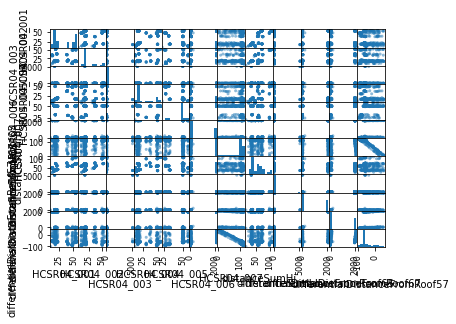

In [37]:
# Scatterplot Matrix
import matplotlib.pyplot as plt
import pandas
from pandas.plotting import scatter_matrix
scatter_matrix(data)
plt.show()

# New Features

Creo delle clonne calcolate che dovrebbero essere meno dipendenti dalla posizione esatta dell'oggetto

In [39]:

url = "https://raw.githubusercontent.com/emanbuc/ultrasonic-vision/main/sample_acquisitions/7sensors/20210102/20210102_alldata.csv"
names = ['HCSR04_001', 'HCSR04_002', 'HCSR04_003', 'HCSR04_004', 'HCSR04_005', 'HCSR04_006', 'HCSR04_007',"ObjectClass"]
data = pandas.read_csv(url, usecols=names)
# somma delle distanze dai sensori bassi montati sui pannelli verticali
data['distanceSumHi'] = data.HCSR04_001 + data.HCSR04_002

# somma delle distanze dai sensori alti  montati sui pannelli orizzontali
data['distanceSumLow'] = data.HCSR04_003 + data.HCSR04_004

# differenza distanza da sensori tetto
data['differentialDistanceFromRoof65'] = data.HCSR04_006 - data.HCSR04_005
data['differentialDistanceFromRoof67'] = data.HCSR04_006 - data.HCSR04_007
data['differentialDistanceFromRoof57'] = data.HCSR04_005 - data.HCSR04_007

print(data)

     HCSR04_001  ...  differentialDistanceFromRoof57
0         53.25  ...                           27.24
1         53.21  ...                          -66.92
2         53.16  ...                          -59.71
3         53.18  ...                          -54.14
4         53.31  ...                          -55.13
..          ...  ...                             ...
496       40.35  ...                          -88.56
497       40.43  ...                          -81.20
498       40.34  ...                          -80.59
499       40.42  ...                          -80.64
500       40.30  ...                          -79.93

[501 rows x 13 columns]


# Elimino letture anomale

Le distanze misurate quando non ci sono oggetti sono i valori massimi che mi aspetto. Valori superiori indicano una anomalia nella misurazione (es. multipah, scattering, ...)

In [40]:
groupedByClass = data.groupby(['ObjectClass'])
groupedByClass.first()

,HCSR04_001,HCSR04_002,HCSR04_003,HCSR04_004,HCSR04_005,HCSR04_006,HCSR04_007,distanceSumHi,distanceSumLow,differentialDistanceFromRoof65,differentialDistanceFromRoof67,differentialDistanceFromRoof57
ObjectClass,,,,,,,,,,,,
BALL_CENTER,55.59,16.09,54.78,17.55,51.73,57.48,96.38,71.68,72.33,5.75,-38.90,-44.65
BEAN_CAN,52.81,15.54,3.97,19.05,50.48,2115.51,109.24,68.35,23.02,2065.03,2006.27,-58.76
BEER_BOTTLE,18.98,18.62,18.80,18.79,50.78,119.22,111.96,37.60,37.59,68.44,7.26,-61.18
EMPTY_SEVEN,53.25,54.19,56.01,53.70,50.57,51.90,23.33,107.44,109.71,1.33,28.57,27.24
GLASS,53.25,18.50,22.04,17.39,49.88,2114.98,104.41,71.75,39.43,2065.10,2010.57,-54.53
RECTANGULAR_BOX,48.56,50.96,14.53,30.73,27.14,25.80,96.35,99.52,45.26,-1.34,-70.55,-69.21
RECTANGULAR_BOX_SIDE,10.36,4.26,35.71,12.94,22.03,23.99,122.23,14.62,48.65,1.96,-98.24,-100.20
SOAP_BOTTLE_FRONT,16.99,15.77,15.69,16.25,50.74,2115.85,111.68,32.76,31.94,2065.11,2004.17,-60.94
SOAP_BOTTLE_SIDE,19.46,53.24,33.39,18.03,50.87,2114.00,107.46,72.70,51.42,2063.13,2006.54,-56.59


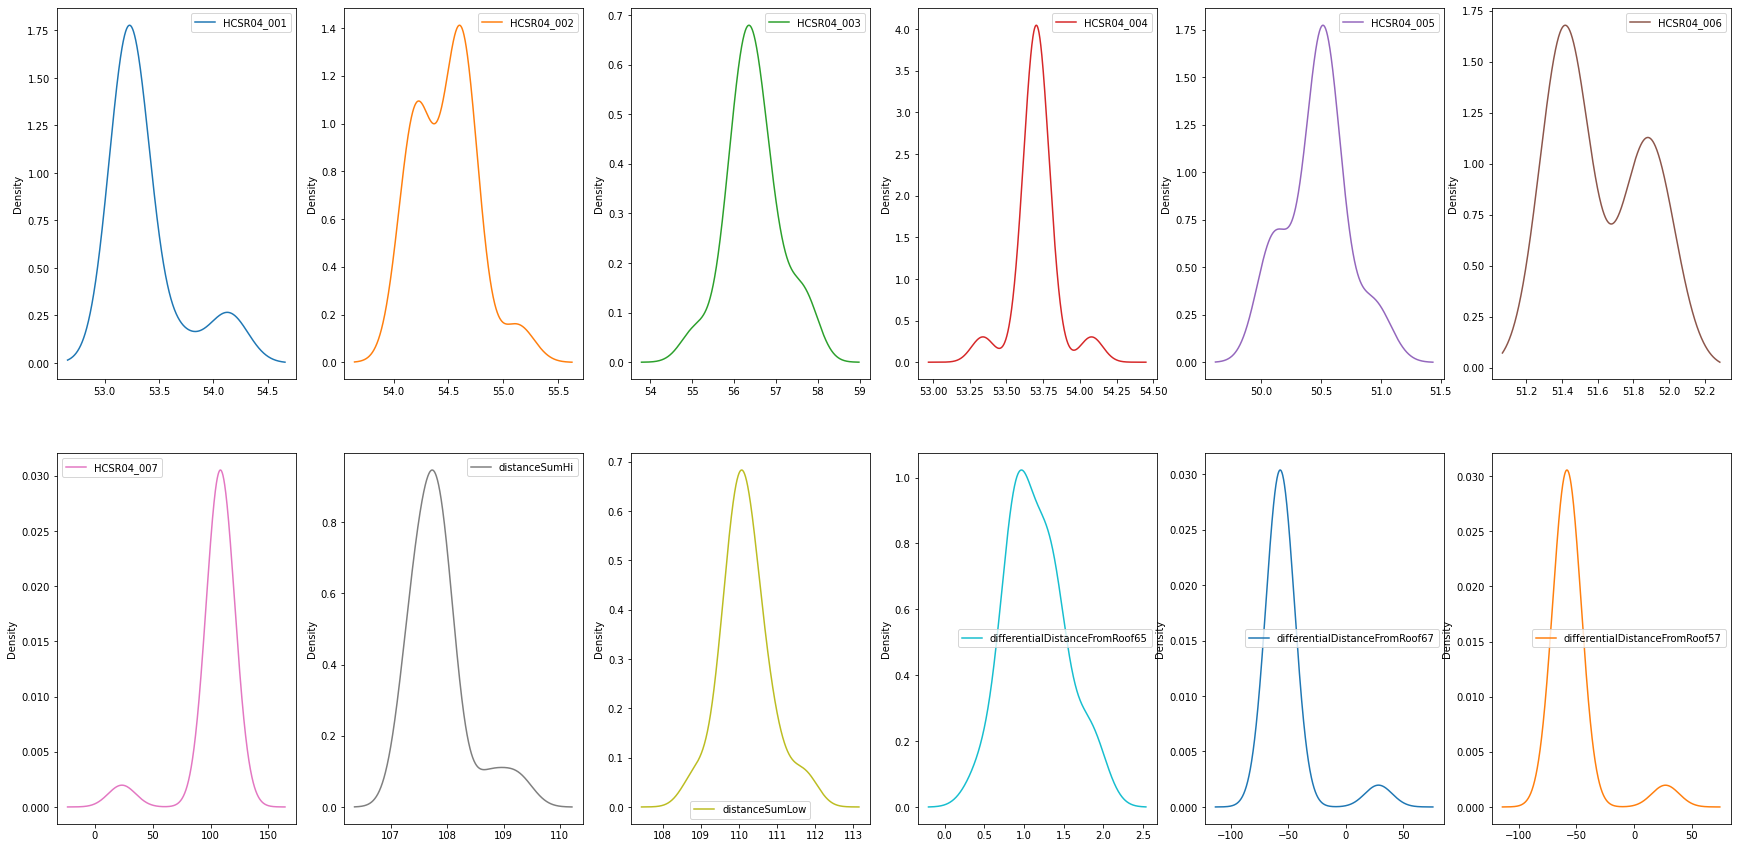

,HCSR04_001,HCSR04_002,HCSR04_003,HCSR04_004,HCSR04_005,HCSR04_006,HCSR04_007,distanceSumHi,distanceSumLow,differentialDistanceFromRoof65,differentialDistanceFromRoof67,differentialDistanceFromRoof57
0,53.25,54.19,56.01,53.70,50.57,51.90,23.33,107.44,109.71,1.33,28.57,27.24
1,53.21,54.23,55.98,53.70,50.49,51.39,117.41,107.44,109.68,0.90,-66.02,-66.92
2,53.16,54.62,56.41,53.72,50.11,51.91,109.82,107.78,110.13,1.80,-57.91,-59.71
3,53.18,54.64,56.03,53.70,50.49,51.44,104.63,107.82,109.73,0.95,-53.19,-54.14
4,53.31,54.58,56.39,53.63,50.11,51.40,105.24,107.89,110.02,1.29,-53.84,-55.13
5,53.18,54.14,55.94,53.70,50.55,51.37,109.74,107.32,109.64,0.82,-58.37,-59.19
6,53.21,54.64,57.64,54.08,50.53,51.83,105.13,107.85,111.72,1.30,-53.30,-54.60
7,53.22,54.16,55.09,53.78,50.89,51.82,110.76,107.38,108.87,0.93,-58.94,-59.87
8,53.26,54.28,57.68,53.34,50.07,51.40,106.17,107.54,111.02,1.33,-54.77,-56.10
9,53.26,54.59,56.43,53.73,50.98,51.46,110.48,107.85,110.16,0.48,-59.02,-59.50


In [41]:
df_EMPTY_SEVEN = groupedByClass.get_group('EMPTY_SEVEN')
df_EMPTY_SEVEN.plot(kind='density', subplots=True, layout=(2,6), sharex=False, figsize=(30,15))
plt.show()
df_EMPTY_SEVEN

La misura del sensore 007 presenta un errore sistematico che sposta il picco da 50cm a 100cm circa

La distanza reale è di circa 50cm

In [43]:
cleanedData= data[(data["distanceSumLow"] <= 200) & (data["HCSR04_006"] <= 100) & (data["HCSR04_005"] <= 100)]

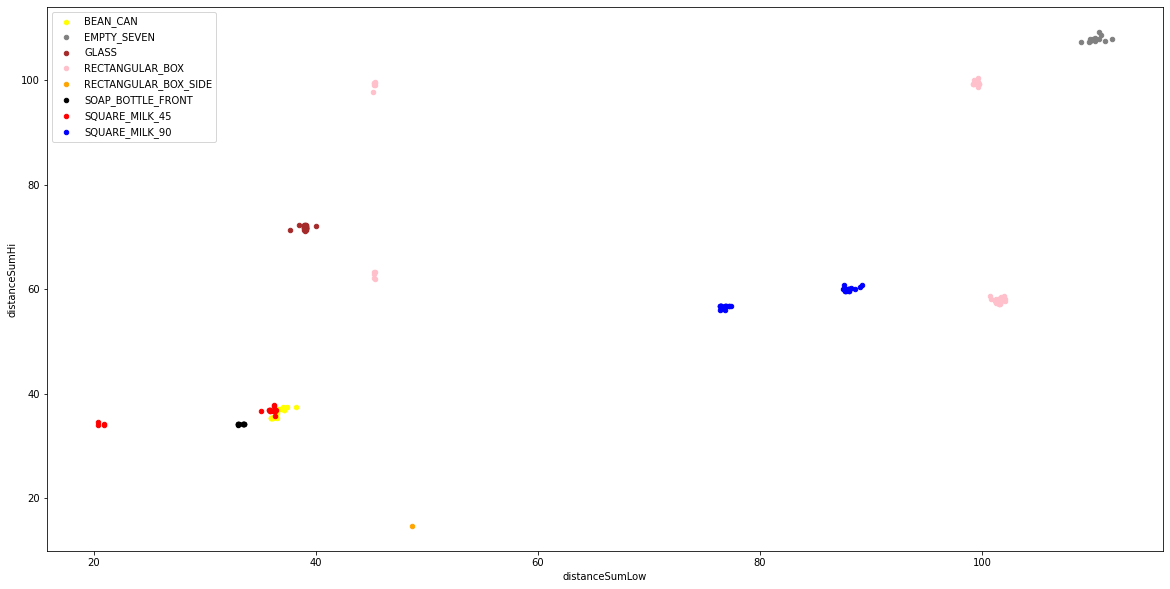

In [44]:

newdf = cleanedData.query('ObjectClass == "SQUARE_MILK_45" | ObjectClass == "SQUARE_MILK_90" | ObjectClass == "SOAP_BOTTLE_FRONT" | ObjectClass == "SOAP_BOTTLE_SIDE" | ObjectClass == "BEAN_CAN" | ObjectClass=="RECTANGULAR_BOX" | ObjectClass=="RECTANGULAR_BOX_SIDE" | ObjectClass=="GLASS" | ObjectClass=="EMPTY_SEVEN"')
fig, ax = plt.subplots()

colors = {'SQUARE_MILK_45':'red', 'SQUARE_MILK_90':'blue', 'SOAP_BOTTLE_SIDE':'green', 'SOAP_BOTTLE_FRONT':'black','BEAN_CAN':'yellow','RECTANGULAR_BOX':'pink', 'RECTANGULAR_BOX_SIDE': 'orange','GLASS':'brown',"EMPTY_SEVEN":'grey'}

groupedByClass = newdf.groupby(['ObjectClass'])
for key, group in groupedByClass:
    group.plot(ax=ax, kind='scatter', x='distanceSumLow', y='distanceSumHi', label=key, legend=True, color=colors[key],figsize=(20,10))

plt.show()

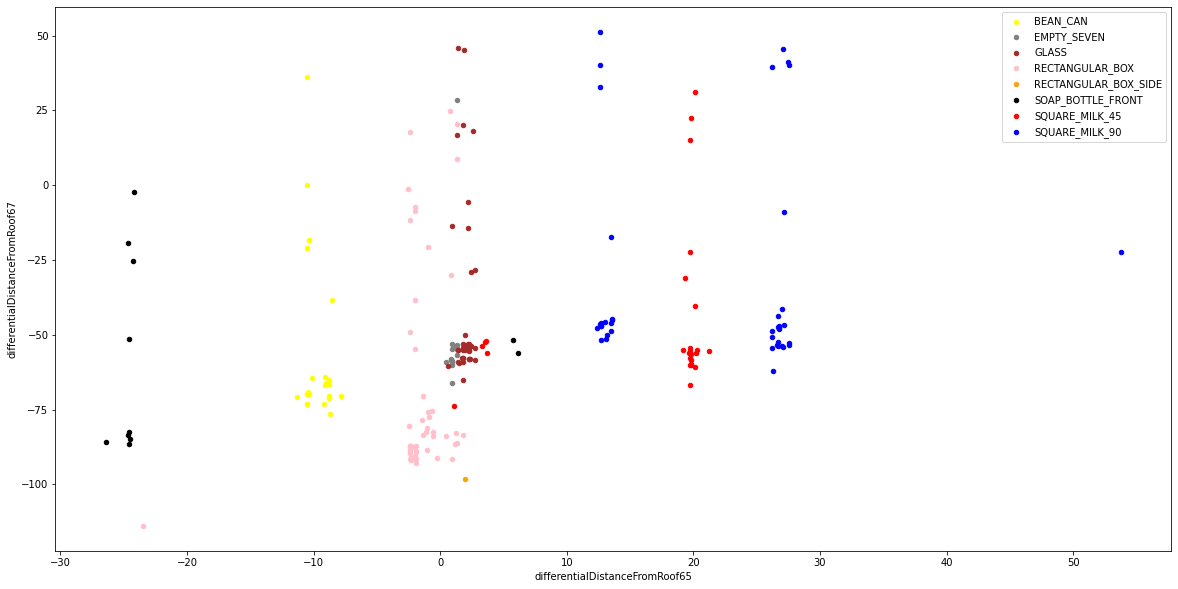

In [45]:
fig, ax = plt.subplots()
for key, group in groupedByClass:
    group.plot(ax=ax, kind='scatter', x='differentialDistanceFromRoof65', y='differentialDistanceFromRoof67', label=key, legend=True, color=colors[key],figsize=(20,10))

plt.show()

Con le nuove feature le classi ora appaiono ben separabili. Esporto il nuovo dataset ripulito.

In [50]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
cleanedData.to_csv('20210102-cleaned',sep=',')
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
uploaded = drive.CreateFile({'title': '20210102-cleaned.csv'})
uploaded.SetContentFile('20210102-cleaned')
uploaded.Upload()